# Table of contents
- [01 Importing Moduls](#01-Importing-Moduls)

### 01 Importing Moduls

In [3]:
#!pip install yfinance 


In [4]:
import numpy as np
import pandas as pd 
import yfinance as yf
import datetime
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import nltk 
from nltk.sentiment.vader import SentimentIntensityAnalyzer as sia
from gensim.parsing.preprocessing import STOPWORDS, strip_tags, strip_numeric, strip_punctuation, strip_multiple_whitespaces, remove_stopwords, strip_short, stem_text
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
plt.style.use('bmh')
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [81]:

# in this case: Zoom
data=yf.download(tickers='ZM', period='max', interval='1d')
data.info()

[*********************100%***********************]  1 of 1 completed
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 547 entries, 2019-04-18 to 2021-06-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       547 non-null    float64
 1   High       547 non-null    float64
 2   Low        547 non-null    float64
 3   Close      547 non-null    float64
 4   Adj Close  547 non-null    float64
 5   Volume     547 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 29.9 KB


In [82]:
data['datetime']=data.index
#data.reset_index()
#data.drop("Date", inplace=True)

In [83]:
!pip install ta # for getting financial indicators 
from ta import add_all_ta_features 


In [84]:
data = add_all_ta_features(
    data, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True)

/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:768: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (self._dip[i] / self._trs[i])
/opt/anaconda3/lib/python3.8/site-packages/ta/trend.py:772: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (self._din[i] / self._trs[i])


In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 547 entries, 2019-04-18 to 2021-06-18
Data columns (total 90 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Open                       547 non-null    float64       
 1   High                       547 non-null    float64       
 2   Low                        547 non-null    float64       
 3   Close                      547 non-null    float64       
 4   Adj Close                  547 non-null    float64       
 5   Volume                     547 non-null    int64         
 6   datetime                   547 non-null    datetime64[ns]
 7   volume_adi                 547 non-null    float64       
 8   volume_obv                 547 non-null    int64         
 9   volume_cmf                 547 non-null    float64       
 10  volume_fi                  547 non-null    float64       
 11  volume_mfi                 547 non-null    float64  

Text(0, 0.5, 'Zoom Opening Stock')

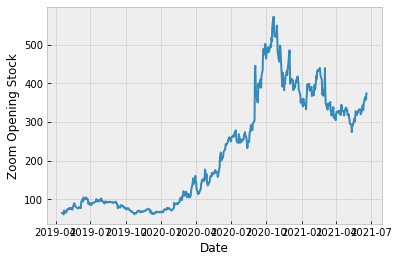

In [55]:
plt.plot(data.datetime,data.Open)
plt.xlabel("Date")
plt.ylabel("Zoom Opening Stock")

In [56]:
#pip install finnhub-python
#!pip install pystan==2.19.1.1.
#!pip install  prophet

In [57]:
import finnhub

# Setup client
finnhub_client = finnhub.Client(api_key="c2si65iad3ic1qis06lg")

In [58]:
def get_news(company, date_from='2020-01-01', date_to=None):
    '''
    returns dataframe with average sentiment of news headline and sentiment of news summary for every date in a given timeframe
    company: symbol, example ZM
    date_from: string format yyyy-mm-dd
    date_to: string format yyyy-mm-dd
    '''
    sid_obj = sia()
    if date_to is None:
        date_to = datetime.date.today().strftime("%Y-%m-%d")
    result=(finnhub_client.company_news(company, _from=date_from, to=date_to))
    news_df = pd.DataFrame(result)
    news_df['datetime'] = [datetime.datetime.utcfromtimestamp(i).strftime('%Y-%m-%d') for i in news_df.datetime]
    news_df.drop(['id','image', 'related','source', 'url'], axis=1, inplace=True)
    news_df['headline_sentiment'] = [sid_obj.polarity_scores(c)['compound'] for c in news_df['headline']]
    news_df['summary_sentiment'] = [sid_obj.polarity_scores(c)['compound'] for c in news_df['summary']]
    news_dates = news_df.groupby(['datetime']).mean().sort_index().reset_index()
    return news_dates

In [85]:
news_dates=get_news("ZM", date_from='2020-01-01')
#news_dates.info()

In [86]:
news_dates['datetime']=news_dates['datetime'].astype('datetime64[ns]')#datetime64
data['datetime']=data['datetime'].astype('datetime64[ns]')
df=news_dates.merge(data,on="datetime",how='inner')

In [61]:
news_dates.tail()

,datetime,headline_sentiment,summary_sentiment
58,2021-06-16,0.000000,0.169444
59,2021-06-17,0.138514,0.339914
60,2021-06-18,0.460917,0.293633
61,2021-06-19,0.374033,0.689467
62,2021-06-20,0.000000,0.000000


In [62]:
df_plot=df[df.datetime > '2021-03-01']

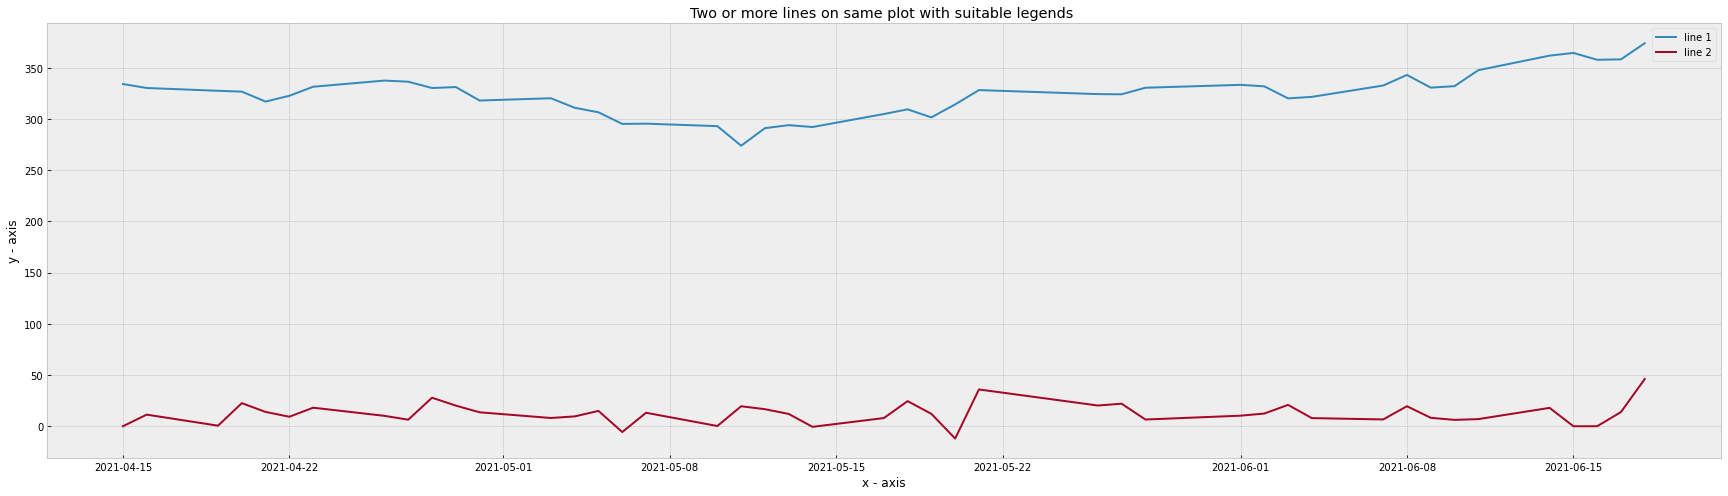

In [63]:
plt.figure(figsize=[30,8])
x1 = df_plot.datetime
y1 = df_plot.Open
# plotting the line 1 points 
plt.plot(x1, y1, label = "line 1")
# line 2 points
x2 = df_plot.datetime
y2 = df_plot.headline_sentiment*100
# plotting the line 2 points 
plt.plot(x2, y2, label = "line 2")
#plt.yscale("log")
plt.xlabel('x - axis')
# Set the y axis label of the current axis.
plt.ylabel('y - axis')
# Set a title of the current axes.
plt.title('Two or more lines on same plot with suitable legends ')
# show a legend on the plot
plt.legend()
# Display a figure.
plt.show()

In [64]:
df.tail()

,datetime,headline_sentiment,summary_sentiment,Open,High,Low,Close,Adj Close,Volume,volume_adi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
40,2021-06-14,0.179308,0.349233,361.869995,369.576996,359.398987,365.910004,365.910004,3444300,2.461623e+08,...,-6.854574,28.563806,334.405004,12.225124,7.730975,6.602297,1.128677,-0.133731,-0.133820,490.177425
41,2021-06-15,0.000000,0.148000,364.500000,364.500000,357.048004,359.000000,359.000000,2587900,2.449301e+08,...,-20.329818,31.061342,336.551973,9.977639,4.265357,6.134909,-1.869552,-1.888443,-1.906502,479.032258
42,2021-06-16,0.000000,0.169444,357.815002,366.829987,355.410004,361.829987,361.829987,2669200,2.452620e+08,...,-14.890361,35.324017,339.045217,9.139441,1.575524,5.223032,-3.647508,0.788297,0.785206,483.596753
43,2021-06-17,0.138514,0.339914,358.204987,374.519989,358.204987,372.950012,372.950012,3416600,2.480211e+08,...,-2.790078,39.612412,345.570746,13.801419,1.075610,4.393548,-3.317938,3.073274,3.026994,501.532278
44,2021-06-18,0.460917,0.293633,374.010010,379.890015,370.929993,374.239990,374.239990,4554400,2.468316e+08,...,-9.166163,41.810456,349.895035,14.407999,3.176012,4.150040,-0.974029,0.345885,0.345288,503.612887


Solving environment: \ ^C
failed with initial frozen solve. Retrying with flexible solve.

Note: you may need to restart the kernel to use updated packages.


# Random Forest for Feature Importance 

In [23]:
#shifting 
move_days = 7

# shifted values column

df["shift_close"]=df[["Close"]].shift(-move_days)

In [26]:
df.tail()

,datetime,headline_sentiment,summary_sentiment,Open,High,Low,Close,Adj Close,Volume,volume_adi,...,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr,shift_close
40,2021-06-14,0.179308,0.349233,361.869995,369.576996,359.398987,365.910004,365.910004,3444300,2.461623e+08,...,28.563806,334.405004,12.225124,7.730975,6.602297,1.128677,-0.133731,-0.133820,490.177425,NaN
41,2021-06-15,0.000000,0.148000,364.500000,364.500000,357.048004,359.000000,359.000000,2587900,2.449301e+08,...,31.061342,336.551973,9.977639,4.265357,6.134909,-1.869552,-1.888443,-1.906502,479.032258,NaN
42,2021-06-16,0.000000,0.169444,357.815002,366.829987,355.410004,361.829987,361.829987,2669200,2.452620e+08,...,35.324017,339.045217,9.139441,1.575524,5.223032,-3.647508,0.788297,0.785206,483.596753,NaN
43,2021-06-17,0.138514,0.339914,358.204987,374.519989,358.204987,372.950012,372.950012,3416600,2.480211e+08,...,39.612412,345.570746,13.801419,1.075610,4.393548,-3.317938,3.073274,3.026994,501.532278,NaN
44,2021-06-18,0.460917,0.293633,374.010010,379.890015,370.929993,374.239990,374.239990,4554400,2.468316e+08,...,41.810456,349.895035,14.407999,3.176012,4.150040,-0.974029,0.345885,0.345288,503.612887,NaN


In [40]:
#x without the nans
X = np.array(df.drop(['shift_close','datetime'],1))[:-move_days]

In [29]:
y=np.array(df['shift_close'])[:-move_days]
#print(y)

[336.88000488 336.42001343 333.48999023 331.25       321.1000061
 319.57000732 313.92001343 304.8500061  297.58999634 293.04998779
 295.23999023 288.48999023 300.25       289.70001221 290.16000366
 307.89001465 308.92999268 312.85998535 310.45999146 324.70999146
 316.3999939  326.04998779 326.42999268 331.52999878 327.72000122
 327.10998535 319.01000977 336.         342.66000366 341.26000977
 333.63000488 346.5        366.3999939  365.91000366 359.
 361.82998657 372.95001221 374.23999023]


In [30]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2)

In [34]:
param_grid = {'min_samples_leaf': [2,3,5,10,20], 'n_estimators': [3,5,10,50,100]}
rf = RandomForestRegressor(random_state = 42)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
             param_grid={'min_samples_leaf': [2, 3, 5, 10, 20],
                         'n_estimators': [3, 5, 10, 50, 100]})

In [35]:
grid_search.best_estimator_

RandomForestRegressor(min_samples_leaf=3, n_estimators=50, random_state=42)

In [37]:
rf=RandomForestRegressor(min_samples_leaf=3, n_estimators=50, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=3, n_estimators=50, random_state=42)

In [41]:
X_pred=df.drop(['shift_close','datetime'],1)[:-move_days]
X_pred=X_pred.tail(move_days)
X_pred=np.array(X_pred)
print(X_pred)

[[ 1.02981481e-01  1.40685185e-01  3.33329987e+02  3.36140015e+02
   3.21700012e+02  3.27720001e+02  3.27720001e+02  6.60710000e+06
   2.35894565e+08  4.09942300e+08  1.44601564e-01  2.59441890e+06
   5.12373516e+01 -8.87320524e+02  9.91400671e+02 -3.30322136e+04
   7.67832131e+02  3.13832780e+02  1.29804821e+01  3.09757497e+02
   3.37633160e+02  2.81881833e+02  1.79983786e+01  8.22189723e-01
   0.00000000e+00  0.00000000e+00  3.21613032e+02  3.32999937e+02
   3.10226127e+02  7.08112158e+00  7.68157557e-01  0.00000000e+00
   0.00000000e+00  2.73200012e+02  3.36329987e+02  3.04764999e+02
   2.03804509e+01  8.63614940e-01  6.06034318e+00  2.33266921e+00
  -1.17609399e+00  3.50876320e+00  3.19651662e+02  3.13496152e+02
   3.20519450e+02  3.18186781e+02  1.34298112e+01  2.29350140e+01
   2.27252099e+01  1.17624176e+00  7.58840869e-01  4.17400892e-01
  -6.64127046e-02  2.48694200e+01  1.01561915e+02 -1.86748199e+00
  -8.68595049e-01 -4.13382876e+01  4.04696925e+01  3.17664993e+02
   3.07440

In [42]:
pred=rf.predict(X_pred)
pred

array([344.51069148, 349.68019729, 353.07249805, 356.93693123,
       357.03519091, 351.38898097, 347.47955198])

## Other try 

In [322]:
X = df.drop(columns=['Close','datetime'], axis=1)
y = df['Close']
#X = np.asarray(X).astype(np.float32)

In [32]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [326]:
X_train, X_test, y_train, y_test=train_test_split(X,y,test_size=0.2)

In [327]:
param_grid = {'min_samples_leaf': [5,10], 'n_estimators': [3,5,10,50]}
rf = RandomForestRegressor(random_state = 42)
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 10)
grid_search.fit(X_train, y_train)



GridSearchCV(cv=10, estimator=RandomForestRegressor(random_state=42),
             param_grid={'min_samples_leaf': [5, 10],
                         'n_estimators': [3, 5, 10, 50]})

In [328]:
grid_search.best_estimator_

RandomForestRegressor(min_samples_leaf=5, n_estimators=50, random_state=42)

In [329]:
rf=RandomForestRegressor(min_samples_leaf=5, n_estimators=10, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(min_samples_leaf=5, n_estimators=10, random_state=42)

In [330]:
y_pred=rf.predict(X_test)

In [331]:
from sklearn.metrics import classification_report

In [332]:
y_pred

array([321.29469368, 326.40258719, 328.183917  , 330.26220274,
       299.36759427, 352.26601774, 323.26647953, 355.02558849,
       314.79860947])

In [333]:
from sklearn import metrics

In [334]:
MSE=metrics.mean_squared_error(y_test,y_pred)
MSE

2573.2439318310594

In [335]:
import shap

In [336]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)


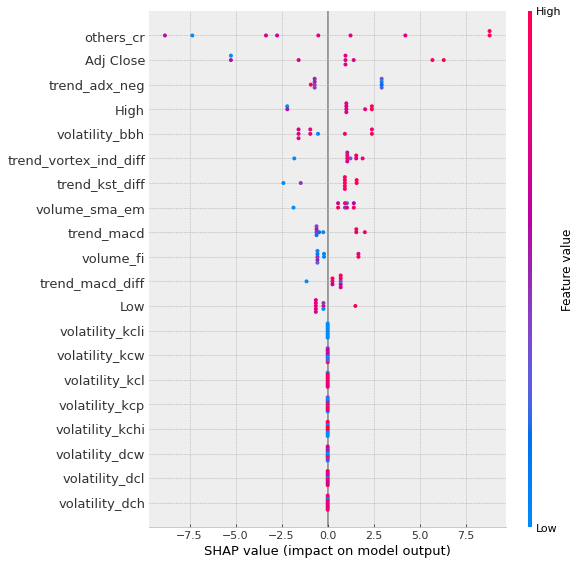

In [337]:
shap.summary_plot(shap_values, X_test,feature_names=X.columns)

In [166]:
df_feature_importance = pd.DataFrame(rf.feature_importances_, index=X.columns, columns=['feature importance']).sort_values('feature importance', ascending=False)
print(df_feature_importance)

                    feature importance
Adj Close                     0.695822
Low                           0.278909
High                          0.025269
headline_sentiment            0.000000
summary_sentiment             0.000000
Open                          0.000000
Volume                        0.000000


In [66]:
# FB Prophet 

In [101]:
from prophet import Prophet
from prophet.plot import plot_plotly

In [87]:
df

,datetime,headline_sentiment,summary_sentiment,Open,High,Low,Close,Adj Close,Volume,volume_adi,...,momentum_wr,momentum_ao,momentum_kama,momentum_roc,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,others_dr,others_dlr,others_cr
0,2020-05-26,0.202300,0.848100,169.100006,169.690002,163.119995,164.000000,164.000000,6689700,4.018691e+07,...,-40.937408,18.210397,163.904497,3.929022,-23.168123,-18.696083,-4.472040,-4.127205,-4.214793,164.516129
1,2021-04-15,0.000000,0.426700,334.144989,338.420013,327.459991,332.380005,332.380005,3360700,2.299012e+08,...,-29.601849,-6.399403,341.863092,7.779107,-11.243080,-13.036523,1.793443,0.965976,0.961340,436.096782
2,2021-04-16,0.113333,0.374867,330.269989,333.750000,326.869995,329.950012,329.950012,2476500,2.296420e+08,...,-35.292701,-4.193097,341.755292,5.351387,-12.912611,-13.011741,0.099130,-0.731089,-0.733774,432.177439
3,2021-04-19,0.005293,0.036893,327.519989,337.795013,320.500000,324.329987,324.329987,3131900,2.278972e+08,...,-48.454359,0.010507,341.676069,0.946179,-12.653903,-12.940173,0.286270,-1.703296,-1.717969,423.112882
4,2021-04-20,0.225430,0.423340,326.730011,327.549988,316.359985,321.779999,321.779999,2282500,2.278258e+08,...,-68.574804,-0.050032,341.337949,-1.364072,-14.358807,-13.223900,-1.134907,-0.786233,-0.789340,418.999998
5,2021-04-21,0.139536,0.305936,317.010010,323.109985,313.500000,322.760010,322.760010,1917500,2.296037e+08,...,-69.736814,-2.494620,341.253629,-0.370410,-16.604041,-13.899928,-2.704112,0.304559,0.304096,420.580661
6,2021-04-22,0.092689,0.255689,322.665009,338.049988,322.665009,328.320007,328.320007,3328300,2.287221e+08,...,-52.318266,-2.561342,341.144188,-0.445739,-14.690295,-14.058002,-0.632293,1.722641,1.707972,429.548399
7,2021-04-23,0.180989,0.168844,331.489990,338.549988,328.239990,336.880005,336.880005,2454300,2.303813e+08,...,-25.824832,-2.012873,340.979157,4.271394,-15.263777,-14.299157,-0.964621,2.607212,2.573803,443.354847
8,2021-04-26,0.101445,0.243973,337.510010,338.000000,329.209991,336.420013,336.420013,2286700,2.318460e+08,...,-27.284196,-1.398728,340.788466,1.551562,-16.059825,-14.651290,-1.408535,-0.136545,-0.136638,442.612925
9,2021-04-27,0.063880,-0.070620,336.390015,341.679993,330.890015,333.489990,333.489990,2208300,2.307019e+08,...,-36.579958,1.346775,340.535403,3.359677,-16.807591,-15.082551,-1.725040,-0.870942,-0.874757,437.887081


In [97]:
data.reset_index(inplace=True)
df_train = data[['datetime','Close']]
df_train = df_train.rename(columns={"datetime": "ds", "Close": "y"})
df_train

,ds,y
0,2019-04-18,62.000000
1,2019-04-22,65.699997
2,2019-04-23,69.000000
3,2019-04-24,63.200001
4,2019-04-25,65.000000
...,...,...
542,2021-06-14,365.910004
543,2021-06-15,359.000000
544,2021-06-16,361.829987
545,2021-06-17,372.950012


In [115]:
m = Prophet(interval_width=0.95)
m.fit(df_train)
future = m.make_future_dataframe(periods=21, freq ='D')
forecast = m.predict(future)

INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [117]:
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
563,2021-07-05,339.340095,307.744927,390.156291,334.496460,343.932563,12.243011,12.243011,12.243011,12.686741,12.686741,12.686741,-0.443730,-0.443730,-0.443730,0.0,0.0,0.0,351.583106
564,2021-07-06,339.093285,310.966649,393.119029,333.442707,344.046884,12.296136,12.296136,12.296136,12.889831,12.889831,12.889831,-0.593694,-0.593694,-0.593694,0.0,0.0,0.0,351.389421
565,2021-07-07,338.846475,308.969729,390.015686,332.871971,344.243317,11.342651,11.342651,11.342651,12.085319,12.085319,12.085319,-0.742668,-0.742668,-0.742668,0.0,0.0,0.0,350.189126
566,2021-07-08,338.599665,308.651694,391.958149,332.423485,344.491413,11.084360,11.084360,11.084360,11.974928,11.974928,11.974928,-0.890568,-0.890568,-0.890568,0.0,0.0,0.0,349.684024
567,2021-07-09,338.352855,309.163196,394.566232,331.697746,344.614190,13.167081,13.167081,13.167081,14.205303,14.205303,14.205303,-1.038221,-1.038221,-1.038221,0.0,0.0,0.0,351.519936


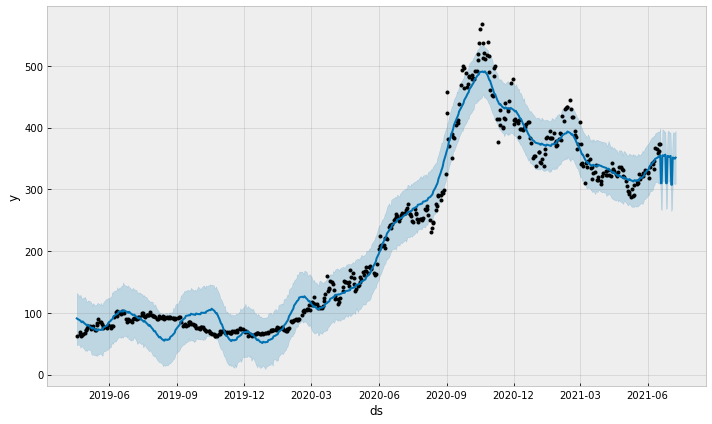

In [118]:
m.plot(forecast)
plt.show()